In [2]:
import requests
import json
import re
import os
import pandas as pd 
import numpy as np
import random
import warnings

from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker, Classifier
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib
import pickle

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
# Set input file directory
ip_file_dir = "../../Data/"

# Get grocery product hierarchy information
group10 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group4_header.csv'),
                      sep=',', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products_group4.csv'))

# Merge scraped information into the hierarchy table
group4 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group4 = preprocess_df(group4)

In [7]:
group4.head(2)

,Unnamed: 0,tcin,item_state,title,update_ts,brand_classification,brand_group,brand_id,brand,class_id,class_name,department_id,department_name,division_id,division_name,estore_item_status_c,estore_item_status,group_id,group_name,has_image,intended_selling_channels,is_published_flag,is_sellable,is_size_mix,is_standard_item,is_targetcom_ready,is_weight_required,item_kind,item_type_category_type,item_type_name,item_type,launch_date_time,manufacturer_brand,net_content_quantity_unit_of_measure,net_content_quantity_value,organic_c,package_depth,package_dimension_unit_of_measure,package_height,package_weight_unit_of_measure,package_weight,package_width,product_subtype_name,product_subtype,product_type_name,product_type,record_source_c,reference_color,reference_pattern_id,reference_size,relationship_kit_type,relationship_type_c,relationship_type,short_desc,size_chart,size_group_name,street_d,style_id,style_name,sub_group_id,sub_group_name,subclass_id,subclass_name,temperature_sensitivity_c,units_per_package,upc,variation_color,variation_other_label,variation_other,variation_size,variation_theme,price,rating,n_reviews,highlights,specifications,description,serving_info,nutrition_info,ingredients,allergens,title_modified
0,19,10252241,READY_FOR_LAUNCH,Houdini Deluxe Lever Corkscrew,2021-10-05 02:17:34,National-National,National,18442.0,Houdini,5,KITCHEN TOOLS & GADGETS,70,KITCHENWARE,35,KITCHEN,A,Active,4,HOME,True,Sold in StoreSold Online,True,True,NaN,NaN,NaN,NaN,NaN,NaN,Corkscrews,104185519,2013-03-03 08:00:00,NaN,EACH,1.0,NaN,8.88,INCH,2.94,POUND,1.21,8.24,BARWARE,616.0,KITCHEN,636.0,Corona,NaN,NaN,NaN,NaN,SA,Stand Alone,CORKSCREW HOUDINI SILVER,NaN,NaN,NaN,070-05-02-AAR98,HOUDINI DLUX CORK,29,KITCHEN,070-05-02,BARWARE,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,29.99,3.6,30.0,"[3 Piece Set (Opener, Foil Cutter & Spiral), B...","[Includes: Bottle Opener, Extra Spiral, Foil C...",A high-quality lever-style corkscrew at a grea...,NaN,NaN,NaN,NaN,houdini deluxe lever corkscrew
1,25,10386198,READY_FOR_LAUNCH,Kitchen Selectives Single Burner,2021-09-14 17:16:29,National-National,National,22771.0,Select Brands,4,SMALL APPLIANCES,72,SMALL APPLIANCES,35,KITCHEN,A,Active,4,HOME,True,Sold Online,True,True,NaN,NaN,NaN,NaN,NaN,NaN,Burners,298450,2006-10-08 07:00:00,NaN,EACH,1.0,NaN,9.50,INCH,4.00,POUND,1.95,10.50,COOKING APPLIANCES,651.0,KITCHEN,636.0,Corona,NaN,NaN,NaN,NaN,SA,Stand Alone,Kitchen Sele KITCH SELECT BURNER,NaN,NaN,NaN,072-04-11-AAB30,BURNER/HOTPLATE,29,KITCHEN,072-04-11,UTILITY APPLIANCES,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,26.49,4.2,60.0,"[Adjustable heat control, 1000 watt burner, Hi...","[, Dimensions (Overall): 2.9 Inches (H) x 8.7 ...",The Kitchen Selectives single burner gives you...,NaN,NaN,NaN,NaN,kitchen selectives single burner


In [8]:
# lm = SentenceTransformer('models/triplet-models/class_name_v2')
# clf = CrossEncoder('models/nli-classification-class_name')
lm = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [9]:
# Get list of preprocessed product titles
product_ids = group4['tcin'].values

In [10]:
group4['class_name'] = np.where(pd.isnull(group10['class_name']), '', group10['class_name'])
group4['subclass_name'] = np.where(pd.isnull(group10['subclass_name']), '', group10['subclass_name'])
# group10['short_desc'] = np.where(pd.isnull(group10['short_desc']), '', group10['short_desc'])
group4['style_name'] = np.where(pd.isnull(group10['style_name']), '', group10['style_name'])
group4['item_type_name'] = np.where(pd.isnull(group10['item_type_name']), '', group10['item_type_name'])
# group10['highlights'] = np.where(pd.isnull(group10['highlights']), '', group10['highlights'])
# group10['description'] = np.where(pd.isnull(group10['description']), '', group10['description'])

product_sentences = list(group4['class_name'].str.cat(group4[['subclass_name', 
                                                                'item_type_name', 
                                                                'style_name', 'title'
                                                        ]], 
                                             sep= ' ').str.lower().values)


In [11]:
# Compute embeddings
pool = lm.start_multi_process_pool(target_devices=['cpu']*8)
emb = lm.encode_multi_process(product_sentences, pool)
# Store sentences & embeddings on disc
with open('../../data/embeddings/hier_embeddings_products4.pkl', "wb") as fOut:
    pickle.dump({'ids': product_ids,
                 'sentences': product_sentences, 
                 'embeddings': emb}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
#Load sentences & embeddings from disc
with open('../../data/embeddings/hier_embeddings_products4.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_ids = stored_data['ids']
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']

In [13]:
tr = TransformerRanker(model=lm, product_ids=product_ids, max_rank=6)
tr.load_embeddings(stored_embeddings)
pm = Mapper(group4)
dp = DisplayProducts(ranker=tr, mapper=pm)

In [17]:
dp.display_products_ingredient('pan', 10)

KeyError: 'image'

In [16]:
group4.head(2)

,Unnamed: 0,tcin,item_state,title,update_ts,brand_classification,brand_group,brand_id,brand,class_id,class_name,department_id,department_name,division_id,division_name,estore_item_status_c,estore_item_status,group_id,group_name,has_image,intended_selling_channels,is_published_flag,is_sellable,is_size_mix,is_standard_item,is_targetcom_ready,is_weight_required,item_kind,item_type_category_type,item_type_name,item_type,launch_date_time,manufacturer_brand,net_content_quantity_unit_of_measure,net_content_quantity_value,organic_c,package_depth,package_dimension_unit_of_measure,package_height,package_weight_unit_of_measure,package_weight,package_width,product_subtype_name,product_subtype,product_type_name,product_type,record_source_c,reference_color,reference_pattern_id,reference_size,relationship_kit_type,relationship_type_c,relationship_type,short_desc,size_chart,size_group_name,street_d,style_id,style_name,sub_group_id,sub_group_name,subclass_id,subclass_name,temperature_sensitivity_c,units_per_package,upc,variation_color,variation_other_label,variation_other,variation_size,variation_theme,price,rating,n_reviews,highlights,specifications,description,serving_info,nutrition_info,ingredients,allergens,title_modified
0,19,10252241,READY_FOR_LAUNCH,Houdini Deluxe Lever Corkscrew,2021-10-05 02:17:34,National-National,National,18442.0,Houdini,5,KITCHEN TOOLS & GADGETS,70,KITCHENWARE,35,KITCHEN,A,Active,4,HOME,True,Sold in StoreSold Online,True,True,NaN,NaN,NaN,NaN,NaN,NaN,Corkscrews,104185519,2013-03-03 08:00:00,NaN,EACH,1.0,NaN,8.88,INCH,2.94,POUND,1.21,8.24,BARWARE,616.0,KITCHEN,636.0,Corona,NaN,NaN,NaN,NaN,SA,Stand Alone,CORKSCREW HOUDINI SILVER,NaN,NaN,NaN,070-05-02-AAR98,HOUDINI DLUX CORK,29,KITCHEN,070-05-02,BARWARE,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,29.99,3.6,30.0,"[3 Piece Set (Opener, Foil Cutter & Spiral), B...","[Includes: Bottle Opener, Extra Spiral, Foil C...",A high-quality lever-style corkscrew at a grea...,NaN,NaN,NaN,NaN,houdini deluxe lever corkscrew
1,25,10386198,READY_FOR_LAUNCH,Kitchen Selectives Single Burner,2021-09-14 17:16:29,National-National,National,22771.0,Select Brands,4,SMALL APPLIANCES,72,SMALL APPLIANCES,35,KITCHEN,A,Active,4,HOME,True,Sold Online,True,True,NaN,NaN,NaN,NaN,NaN,NaN,Burners,298450,2006-10-08 07:00:00,NaN,EACH,1.0,NaN,9.50,INCH,4.00,POUND,1.95,10.50,COOKING APPLIANCES,651.0,KITCHEN,636.0,Corona,NaN,NaN,NaN,NaN,SA,Stand Alone,Kitchen Sele KITCH SELECT BURNER,NaN,NaN,NaN,072-04-11-AAB30,BURNER/HOTPLATE,29,KITCHEN,072-04-11,UTILITY APPLIANCES,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,26.49,4.2,60.0,"[Adjustable heat control, 1000 watt burner, Hi...","[, Dimensions (Overall): 2.9 Inches (H) x 8.7 ...",The Kitchen Selectives single burner gives you...,NaN,NaN,NaN,NaN,kitchen selectives single burner


In [13]:
df = pd.DataFrame()
df['ids'] = stored_data['ids']
df['sentences'] = stored_data['sentences']
print(df[df['ids'] == 82427725]['sentences'].values)


['dsd base water dsd store option water dsd store option evian natural spring water - 33.8 fl oz bottle']


In [14]:
bi_encoder_name = "multi-qa-MiniLM-L6-cos-v1"
cross_encoder_name = "cross-encoder/ms-marco-MiniLM-L-4-v2"
classifier_name = 'model/nli-classification-class_name'
k=3

In [15]:
base_clf = CrossEncoder('models/nli-classification-class_name')
clf = Classifier(clf, pm, 'class_name')

In [16]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

bi_encoder = SentenceTransformer(bi_encoder_name)

# Get list of preprocessed product titles
product_titles = group10['title'].str.lower().values

l1_ranker = TransformerRanker(model=bi_encoder, 
                              product_ids=group10['tcin'], 
                              max_rank=3,
                              clf=clf)
with open('data/hier_embeddings3.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_ids = stored_data['ids']
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']
df = pd.DataFrame()
df['id'] = stored_data['ids']
df['sentence'] = stored_data['sentences']
l1_ranker.load_embeddings(stored_embeddings)

cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)
l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map('data/hier_embeddings3.pkl'),
                                cross_rank=k,
                                bi_rank=30)

pm = Mapper(group10)
dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

In [17]:
ingredient = 'water'
l1_ranker.rank_products_ingredient(ingredient, 3)

Filtered water for class_name: DC BASE WATER


[13052275, 14150940, 14127478]

In [18]:
ingredient = 'black pepper'
tcin_list = l1_ranker.rank_products_ingredient(ingredient, 100)
tcin_list = clf.filter_by_class(ingredient, tcin_list)

Filtered black pepper for class_name: MEXICAN/BADIA/GOYA
Filtered black pepper for class_name: MEXICAN/BADIA/GOYA


In [19]:
# dp.display_products_ingredient_tcins(tcin_list[0:10])

Filtered salt for class_name: SPICES
salt
[78140861, 47094599, 13171236, 13171237, 78140513, 13170337, 13406684, 13170448, 13170338, 13012161]


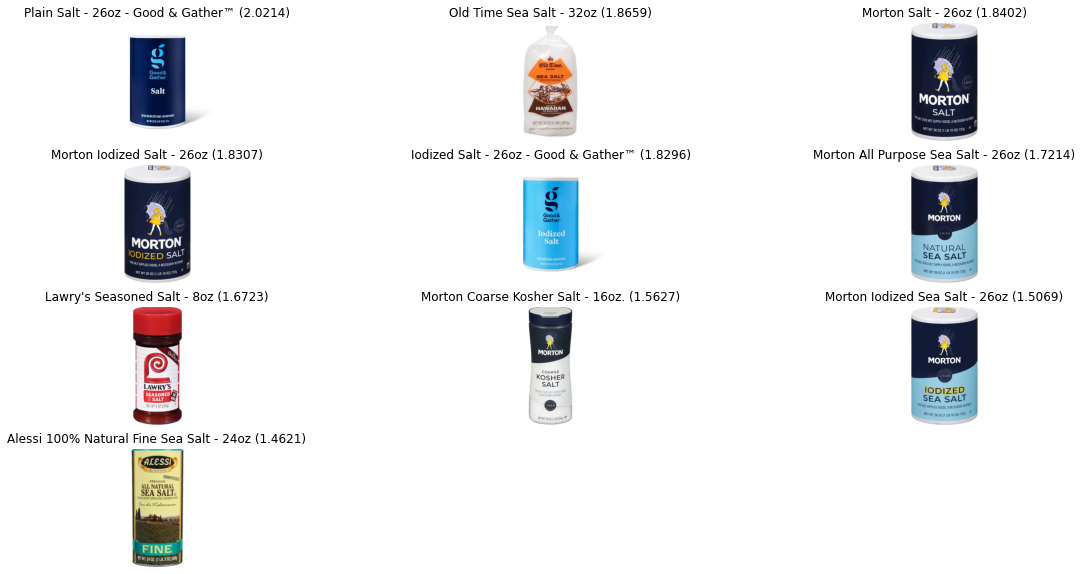

In [23]:
dp.display_products_ingredient('salt', 10)